# Hierarchical Attention Network for Document Classification


# Import libraries


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import plot_model, np_utils
from keras.utils.np_utils import to_categorical

Using Theano backend.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leehe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leehe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leehe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Functions

In [2]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data

def to_categorical(series,class_dict):
    """
    Converts category labels to vectors,
    Input:     series     - pandas Series containing numbered category labels
               class_dict - dictionary of integer to category string 
                            e.g. {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
    Output:    Array      - numpy array containing categories converted to lists
                            e.g. 0:'business'      -> [1 0 0 0 0]
                                 1:'entertainment' -> [0 1 0 0 0]
                                 2:'politics'      -> [0 0 1 0 0]
                                 3:'sport'         -> [0 0 0 1 0]
                                 4:'tech'          -> [0 0 0 0 1]
    """
    n_classes = len(class_dict)
    new_dict = {}
    for key,value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key,value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)

# Attention layer

In [3]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# Load data
> BBC Dataset contains 2225 news articles from the bbc news website from 2004-2005
> The dataset was accumulated by D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006  
> Source: http://mlg.ucd.ie/datasets/bbc.html  
> Classes are: business, entertainment, politics, sport, tech
Directory structure for the dataset shoud be as shown here:  
  
>Current directory:  
>bbc:   
...||--business  
...||--entertainment  
...||--politics  
...||--sport  
...||--tech  

In [4]:
# Current working directory(directory which contains these jupyter notebook)
"""
Reads the current working directory and searches for the directory 'bbc'.
Every sub directory in directory 'bbc' is searched for .txt files.
Every .txt file is read and saved. The sub directory name containt the .txt file is used the label.
"""
filepath = os.path.join(os.getcwd(),"bbc")
articles = []
category_num = {}
count = 0
for item in os.listdir(filepath):
    category_num[item] = count
    count += 1
    if os.path.isdir(os.path.join(filepath,item)):
        sub_dir = os.path.join(filepath,item)
        files = [f for f in os.listdir(sub_dir) 
         if os.path.isfile(os.path.join(sub_dir,f))]
        for file in files:
            with open(os.path.join(sub_dir,file)) as text:
                data = text.read()
                paragraphs = data.split('\n', -1)
                title = paragraphs[0] + '. '
                paragraphs[0] = title
                data = ''.join(paragraphs)
                articles.append((data,item))

data_df = pd.DataFrame(data=articles,columns=['Text',"Category"])

In [5]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(data_df.shape[0]):
    sent = tokenize.sent_tokenize(data_df.loc[i,'Text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/data_df.shape[0]))

Average number of words in each sentence:  26
Average number of sentences in each document:  17


# Parameters

In [6]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

# Data Preprocessing

In [7]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

Word list is emptyes cleaned.
Word list is emptyes cleaned.
Word list is emptyes cleaned.
Word list is emptyes cleaned.
Word list is emptyes cleaned.
Word list is empty
Word list is emptyes cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is empty
Word list is empty
Word list is empty
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is empty
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.
Word list is emptyles cleaned.


,Text,Category,Code
0,ad sale boost time warner profit . quarterly p...,business,0
1,dollar gain greenspan speech . dollar hit high...,business,0
2,yukos unit buyer face loan claim . owner embat...,business,0
3,high fuel price hit ba profit . british airway...,business,0
4,pernod takeover talk lift domecq . share uk dr...,business,0


# Tokenization

In [8]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = data_cleaned['Text'].shape[0]
for i in range(n):
    s = data_cleaned['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

## GloVe Embedding Matrix

In [9]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')

Found 400000 word vectors.
Total absent words are 1409 which is 5.57 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


# Splitting Data Set

In [10]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
Total:  2225
Training:  1781 , Percentage:  0.8004494382022472
Validation:  222 , Percentage:  0.0997752808988764
Test: 222 , Percentage:  0.0997752808988764


# HAN MODEL

In [11]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 100)           2531300   
_________________________________________________________________
word_gru (Bidirectional)     (None, 50, 100)           45300     
_________________________________________________________________
word_dense (Dense)           (None, 50, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 100, 10200     
Total params: 2,596,900
Trainable params: 65,600
Non-trainable params: 2,531,300
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              P

## Train

Train on 1781 samples, validate on 222 samples
Epoch 1/7
1781/1781 [==============================] - 78s 44ms/step - loss: 1.1620 - acc: 0.5188 - val_loss: 0.4292 - val_acc: 0.9099
Epoch 2/7
1781/1781 [==============================] - 76s 43ms/step - loss: 0.2949 - acc: 0.9085 - val_loss: 0.1181 - val_acc: 0.9595
Epoch 3/7
1781/1781 [==============================] - 75s 42ms/step - loss: 0.1391 - acc: 0.9624 - val_loss: 0.0763 - val_acc: 0.9820
Epoch 4/7
1781/1781 [==============================] - 75s 42ms/step - loss: 0.1082 - acc: 0.9657 - val_loss: 0.0777 - val_acc: 0.9730
Epoch 5/7
1781/1781 [==============================] - 77s 43ms/step - loss: 0.0843 - acc: 0.9742 - val_loss: 0.0614 - val_acc: 0.9730
Epoch 6/7
1781/1781 [==============================] - 81s 45ms/step - loss: 0.0732 - acc: 0.9781 - val_loss: 0.0744 - val_acc: 0.9685
Epoch 7/7
1781/1781 [==============================] - 75s 42ms/step - loss: 0.0599 - acc: 0.9792 - val_loss: 0.0690 - val_acc: 0.9640
dict_key

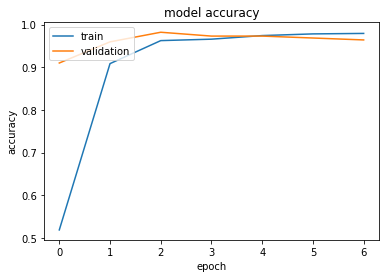

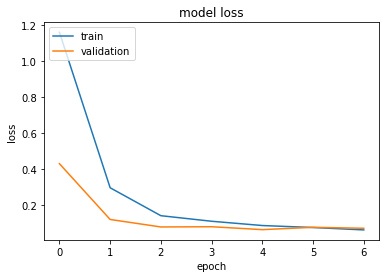

In [12]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=50)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test

In [13]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

222/222 [==============================] - 3s 14ms/step
Test set accuracy:  0.954954954954955
Test set loss:  0.12532140176978196


## Save Model

In [14]:
# Saves the model in a hdf5 file
model.save('Model_7epoch.h5')  

# Application
> Trained HAN model is used to classify new BBC news articles, as well as creating a short summary of the article using sentence attention weights.  
> Words with most attention are used as new tags
> Database can be created with tagges, summarized news articles

In [24]:
# Load model from saved hdf5 file
model = load_model('Model_7epoch.h5',custom_objects={'AttentionLayer': AttentionLayer})

articleDB = pd.DataFrame(columns = ['Title','Summary','Text','Category','Tags'])

## Input text
> This scrapes the website and saves the title and text.  
> Text is then cleaned as described earlier and converted to a sequence of numbers.

In [49]:
# Input url of interested article
#article_url = 'https://www.bbc.com/news/business-47068401'
#article_url = 'https://www.bbc.com/news/technology-47071334'
#article_url = 'https://www.bbc.com/news/entertainment-arts-39083228'
article_url = 'https://www.bbc.com/news/newsbeat-47069144'
page = requests.get(article_url) 
soup = BeautifulSoup(page.content,'lxml')

# Get title
articlebody = soup.find("div", {"class": "story-body"})
article_title = soup.find("h1",{"class":"story-body__h1"}).text
print(article_title)

# Get news article
story = soup.find("div", {"class": "story-body__inner"}).findAll('p')
article = []
for p in story:
    p_class = p.get('class')
    if p_class:
        no_twite = [x for x in p_class if "twite" not in x]
        no_intro = [x for x in p_class if "story-body__introduction" not in x]
        if no_twite and no_intro:
            article.append(p.text)
    else:
        article.append(p.text)
article = ' '.join(article)
print(article)

# Clean article with pre described rules
article_cleaned,idx_list = cleanString(article,stopWords)
input_array = wordToSeq(article_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

Women in film: 'We're living in the dark ages when it comes to representation'
That's the norm when it comes to Hollywood's biggest films, according to US campaign group, Time's Up. They've shared figures which reveal only 4% of the biggest earning films from the past decade have been directed by women. And now they're calling on Hollywood studios and stars to change that. Time's Up has launched the #4percentchallenge, and stars Tessa Thompson, Brie Larson and Bryce Dallas Howard are among the names to lend their support. Time's Up's campaign to draw attention to this inequality has been welcomed by rising female film talent here in the UK. "Four percent is a pretty depressing figure, but things like this challenge are absolutely necessary," British director Georgia Parris told Radio 1 Newsbeat. She premiered her first full-length film, Mari, at the BFI Film Festival. "It's that age-old problem that women are hired on experience and men are hired on potential. "So if we're not being gi

## Sentence Attention Model
> Model to get attention weights for each sentence

In [50]:
sent_att_weights = Model(inputs=sent_input,outputs=sent_coeffs)
output_array = sent_att_weights.predict(np.resize(input_array,(1,MAX_SENTENCE_NUM,MAX_WORD_NUM)))

# Get n sentences with most attention in document
n_sentences = 5
sent_index = output_array.flatten().argsort()[-n_sentences:]
sent_index = np.sort(sent_index)
sent_index = sent_index.tolist()

# Create summary using n sentences
sent_list = tokenize.sent_tokenize(article)
summary = [sent_list[i] for i in sent_index]

### Word Attention Model
> Model to get attention weights for each word..  
> A new model is build to get the normally hidden word attention weights.

In [51]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

# Summary as input for word attention
summary_cleaned, summary_idx = cleanString(' '.join(summary),stopWords)
word_input_array = wordToSeq(summary_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

# Create model from word input to output of dense layer right before the attention layer
hidden_word_encoding_out = Model(inputs=wordEncoder.input, outputs=wordEncoder.get_layer('word_dense').output)
# Load weights from trained attention layer
word_context = wordEncoder.get_layer('word_attention').get_weights()
# Compute output of dense layer
hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# Compute context vector using output of dense layer
ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [52]:
# Get n words with most attention in document
n_words = 5

flattenlist = []
words_unpadded = []
for idx,sent in enumerate(tokenize.sent_tokenize(summary_cleaned)):
    if(idx>=MAX_SENTENCE_NUM):
        break
    attword_list = tokenize.word_tokenize(sent.rstrip('.'))
    ait_short = (1000*ait[idx][:len(attword_list)]).tolist()
    words_unpadded.extend(ait_short)
    flattenlist.extend(attword_list)

    
words_unpadded = np.array(words_unpadded)
sorted_wordlist = [flattenlist[i] for i in words_unpadded.argsort()]

mostAtt_words = []
i = 0
for word in reversed(sorted_wordlist):
    if word not in mostAtt_words:
        mostAtt_words.append(word)
        i += 1
    if(i>=n_words):
        break

# Output

In [55]:
#Category
res = model.predict(np.expand_dims(input_array,axis=0)).flatten()
cat = categoryToCode[np.argmax(res.flatten())]

# Display information
display(HTML('<h2>'+article_title.rstrip('.')+'</h2>'))
print(cat,mostAtt_words)

display(HTML('<h5>Summary of article:</h5>'))
display(' '.join(summary))

display(HTML('<h5>Full text:</h5>'))
display(article)

entertainment ['bfi', 'film', 'directed', 'event', 'screened']


"They've shared figures which reveal only 4% of the biggest earning films from the past decade have been directed by women. And now they're calling on Hollywood studios and stars to change that. Time's Up's campaign to draw attention to this inequality has been welcomed by rising female film talent here in the UK. Time's Up claims movies directed by women are more inclusive for girls and women, female characters over 40 and racial and ethnic groups. Efforts have been made in the UK to raise female representation, such as 38% of the films screened at the 2018 BFI Film Festival (a major London event) being directed by women."

'That\'s the norm when it comes to Hollywood\'s biggest films, according to US campaign group, Time\'s Up. They\'ve shared figures which reveal only 4% of the biggest earning films from the past decade have been directed by women. And now they\'re calling on Hollywood studios and stars to change that. Time\'s Up has launched the #4percentchallenge, and stars Tessa Thompson, Brie Larson and Bryce Dallas Howard are among the names to lend their support. Time\'s Up\'s campaign to draw attention to this inequality has been welcomed by rising female film talent here in the UK. "Four percent is a pretty depressing figure, but things like this challenge are absolutely necessary," British director Georgia Parris told Radio 1 Newsbeat. She premiered her first full-length film, Mari, at the BFI Film Festival. "It\'s that age-old problem that women are hired on experience and men are hired on potential. "So if we\'re not being given the opportunities to gain that experience then how is the proble

## Article Database

In [54]:
# Add to database
articleDB.loc[len(articleDB.index)] = [sent_list[0].rstrip('.'),
                                       ''.join(summary),
                                       article,
                                      cat,
                                      mostAtt_words]
display(articleDB)

,Title,Summary,Text,Category,Tags
0,"Holy recasting, Batman!",Affleck had been due to direct as well as star...,"Holy recasting, Batman! The search is on for a...",entertainment,"[upcoming, star, sequel, 1960s, tim]"
1,Facebook said participating teens had provided...,It has also emerged that Google ran a similar ...,Facebook said participating teens had provided...,tech,"[data, encrypted, device, access, apps]"
2,"In the final three months of 2018, the economy...","In the final three months of 2018, the economy...","In the final three months of 2018, the economy...",business,"[eurozone, said, economic, data, economy]"
3,That's the norm when it comes to Hollywood's b...,They've shared figures which reveal only 4% of...,That's the norm when it comes to Hollywood's b...,entertainment,"[bfi, film, directed, event, screened]"
